### Generation of unoptimized circuit

In [13]:
### Input information ###

num_samples = 1
nqubits = 3
with_swap_option = True # If True, the MCR swap is executed (then the unoptimized circuit becomes longer)
# Number of iterations for the unoptimized circuit
unopt_iteration_count = nqubits ** 2

Define the input circuit using the PauliRotationSequence class.

In PauliRotationSequence, you first specify the number of qubits to be used.

Next, you use the `add_gate` method to add gates. The first argument specifies the location (index) of the gate as a tuple, and the second argument specifies the rotation axis of the rotation gate. The unoptimization of the circuit will execute the added gates after sorting them in dictionary order based on the first argument's tuple.

The rotation axis represents a rotation of $\pi /4$ when you use $+$ and a rotation of $-\pi /4$ when you use $-$.

For example, if you want to input a 5-qubit circuit

$$
\left[ R_{XYZIZ}\left( \pi /4 \right), R_{ZYIZX}\left( -\pi /4 \right) \right]
$$

you would add it as follows:
```python
circuit = PauliRotationSequence(nqubits)
circuit.add_gate((0,), "+XYZIZ")
circuit.add_gate((1,), "-ZYIZX")
```

Alternatively, you can perform the same operation using `stim.PauliString`.

```python
circuit = PauliRotationSequence(nqubits)
circuit.add_gate((0,), stim.PauliString(f"+{initial_pauli_string}"))
circuit.add_gate((1,), stim.PauliString(f"-{initial_pauli_string}"))
```

By using the method `.get_all()`, you can retrieve all the information about the gates added to the circuit (the gates are sorted and output in the order they are applied to the quantum state).

In [14]:
from mcr.rotation_circuit import PauliRotationSequence

# Example (4 qubit quantum circuit): [R_{ZZZZ}(+pi/4), R_{ZZZZ}(-pi/4)]
input_seq = PauliRotationSequence(nqubits)
initial_pauli_string = "Z" * nqubits
input_seq.add_gate((0,), f"+{initial_pauli_string}")
input_seq.get_all()

[((0,), stim.PauliString("+ZZZ"))]

Since the rotation angles are restricted to $\pm \pi/4$, the PauliRotationSequence can be exactly decomposed into the Clifford+T gate set.
To obtain the circuit decomposed into Clifford+T, use the ``.set_circuit()`` method.
This will provide the quantum circuit described in ``qulacs``.
This quantum circuit can be visualized using ``qulacsvis``.

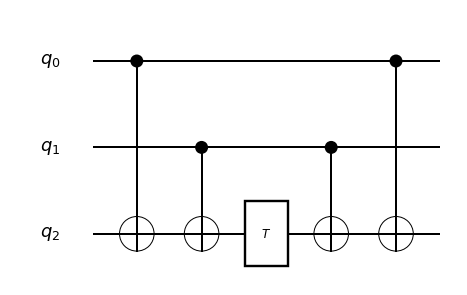

In [15]:
from qulacsvis import circuit_drawer as draw
qulacs_input_circuit = input_seq.set_circuit()
# Draw the circuit
draw(qulacs_input_circuit, "mpl")

In this example of the circuit,
$$
\left[ R_{ZZZZ}\left( \pi /4 \right) \right]
$$
is used, so the optimal T count for this circuit is 1.

Next, we will use the ``unoptimize_circuit`` function to obtain the unoptimized circuit.

In [16]:
from mcr.unoptimize import unoptimize_circuit
# duplicate the circuit
initial_seq = input_seq.duplicate()

# Perform unoptimization

unopt_seq = unoptimize_circuit(input_seq, unopt_iteration_count, with_swap_option)
if nqubits <= 6:
    assert unopt_seq.is_equivalent(initial_seq), "The circuit is not equivalent to the original one."

In [17]:
# Save input and output circuits by QASM format
input_circuit_filepath = "circuit_data/input_circuit.qasm"
unopted_circuit_filepath = "circuit_data/unopted_circuit.qasm"

initial_seq.save_qasm(input_circuit_filepath)
unopt_seq.save_qasm(unopted_circuit_filepath)

### Compiler evaluation

In [18]:
from mcr.optimize import tket_optimization, pyzx_optimization, tmerge_optimization, fasttodd_optimization
# Pytket optimization
df_tket = tket_optimization(input_circuit_filepath, unopted_circuit_filepath)

# PyZX optimization
df_pyzx = pyzx_optimization(input_circuit_filepath, unopted_circuit_filepath)

# TMerge optimization (Note that arguments are PauliRotationSequence)
df_tmerge = tmerge_optimization(nqubits=nqubits,
                    input_seq=initial_seq,
                    unopted_seq=unopt_seq)

In [19]:
# FastTODD optimization (long execution time)
df_fasttodd = fasttodd_optimization(unopted_circuit_filepath)

### Show results

In [20]:
df_tket

,input_circuit,unopted_circuit
before_opt,1,107
after_opt,1,99


In [21]:
df_pyzx

,input_circuit,unopted_circuit
before_opt,1,107
after_opt,1,77


In [22]:
df_tmerge

,input_circuit,unopted_circuit
before_opt,1,107
after_opt,1,77


In [23]:
df_fasttodd

,added_ancilla,after_opt_T_count
0,50,77
